In [1]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless"



In [2]:
#general
import os, sys
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import random

# tensore flow
import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras import layers

# chart
import matplotlib.pyplot as plt
import seaborn as sns

#image
import pydicom
import cv2


#sklearn
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.model_selection import train_test_split

#google colab
from google.colab import drive

# othres
import warnings

warnings.simplefilter("ignore")

In [3]:
os.listdir("/content/")

['.config', 'drive', 'sample_data']

In [4]:
# mount data
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
print(os.listdir("/content/drive/MyDrive/kaggle/kaggle_rsna2022"))
path_home = r"/content/drive/MyDrive/kaggle/kaggle_rsna2022"
os.chdir(path_home)

['.git', 'protos', 'input', 'wandb', '.gitignore', 'df_train.pkl', 'train_path.csv', 'rsna_eda.ipynb', 'rsna_cnn-bench-marking.ipynb']


# 02. Load data frame for meta-data

In [6]:
df_train = pd.read_pickle("df_train.pkl")


In [7]:
df_test = pd.read_csv("input/rsna-breast-cancer-detection/test.csv")

In [8]:
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,input/rsna-breast-cancer-detection/train_image...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,input/rsna-breast-cancer-detection/train_image...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,input/rsna-breast-cancer-detection/train_image...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,input/rsna-breast-cancer-detection/train_image...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,input/rsna-breast-cancer-detection/train_image...


# 1. showing image with pydicom

load 5 samples and show thier images 

34807
input/rsna-breast-cancer-detection/train_images/47352/1580803821.dcm
9237
input/rsna-breast-cancer-detection/train_images/19884/925458668.dcm
200
input/rsna-breast-cancer-detection/train_images/10234/173054723.dcm
47604
input/rsna-breast-cancer-detection/train_images/61198/460866307.dcm
31690
input/rsna-breast-cancer-detection/train_images/44000/1637394322.dcm


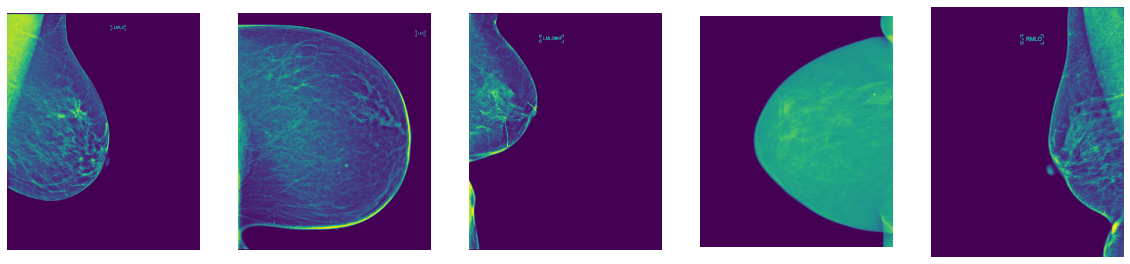

In [9]:
#path_image = df_train['path'].iloc[0]

print("load 5 samples and show thier images \n")
sample_size = 5
indices_samples = df_train.sample(sample_size).index
fig, axes = plt.subplots(1, sample_size, figsize=(20,5))

for i, index in enumerate(indices_samples):
  print(index)
  path_image = df_train.loc[index, 'path']
  print(path_image)
  img = pydicom.dcmread(path_image).pixel_array
  axes[i].imshow(img)
  axes[i].axis("off")

# 2. Preprocessing 

## 2.1 pick up features for training

In [10]:

common_features = list(set(df_train.columns) & set(df_test.columns))
print("common features are")
print(common_features)
print("\n")

print("We will also use 'cancer' and 'path' for training.\n")

features_training = common_features
for feature in ['cancer', 'path']:
  features_training.append(feature)

print("So features to be used for training are ")
print(features_training)

train = df_train[features_training]

common features are
['image_id', 'site_id', 'implant', 'laterality', 'view', 'patient_id', 'age', 'machine_id']


We will also use 'cancer' and 'path' for training.

So features to be used for training are 
['image_id', 'site_id', 'implant', 'laterality', 'view', 'patient_id', 'age', 'machine_id', 'cancer', 'path']


# 3.Preprocessing

## 3.1 Label Encoding

In [11]:
train.dtypes

image_id        int64
site_id         int64
implant         int64
laterality     object
view           object
patient_id      int64
age           float64
machine_id      int64
cancer          int64
path           object
dtype: object

In [12]:
le_laterality = LabelEncoder()
le_view = LabelEncoder()

train['laterality'] = le_laterality.fit_transform(train['laterality'])
train['view'] = le_view.fit_transform(train['view'])

## 3.2 filling na 

In [13]:
train.isnull().sum()

print("only age has null values")

mean_age = int(train["age"].mean())
print("fill na with {}".format(mean_age))

train["age"] = train["age"].fillna(mean_age)

only age has null values
fill na with 58


# 4. Base Line with Kears

- test CNN work
- train_test_split
- sample_size = 3

## 4.1 setting seed

In [14]:
seed = 1234
np.random.seed(seed)
random.seed(seed)

In [15]:
sample_size = 10 #10images on bath cancer:0 and :1

indices_samples = train.loc[train['cancer']==0].sample(sample_size, random_state=seed).index
_indices_samples = train.loc[train['cancer']==1].sample(sample_size, random_state=seed).index

indices_samples = np.append(indices_samples, _indices_samples)
print(indices_samples)
indices_train, indices_valid = train_test_split(indices_samples)

[19628 13367 50618 45217 35152 54370 21516 46263 15805 27830  7084 24184
 35666 36217  7806 46859 51583 51635 14901 46281]


In [16]:
train_images = []

for index in indices_train:
  path = train.loc[index, 'path']
  img = pydicom.dcmread(path).pixel_array
  #print("shape:{}, aspect:{}".format(img.shape, img.shape[0]/img.shape[1]))
  #plt.imshow(img)
  #plt.axis('off')
  #plt.show()
  #train_images = np.append(train_images, img)
  train_images.append(img)
train_images = np.array(train_images)
train_images.shape

(15,)

In [17]:
valid_images = []

for index in indices_valid:
  path = train.loc[index, 'path']
  img = pydicom.dcmread(path).pixel_array
  #print("shape:{}, aspect:{}".format(img.shape, img.shape[0]/img.shape[1]))
  #plt.imshow(img)
  #plt.axis('off')
  #plt.show()
  #train_images = np.append(train_images, img)
  valid_images.append(img)
valid_images = np.array(valid_images)
valid_images.shape

(5,)

In [18]:
train_y = df_train.loc[indices_train,"cancer"]
valid_y = df_train.loc[indices_valid,"cancer"]
train_y
valid_y

45217    0
36217    1
50618    0
51583    1
7806     1
Name: cancer, dtype: int64

## the effect of resizing

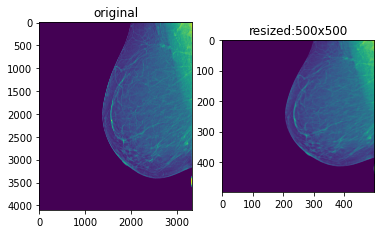

In [19]:
fig, axes = plt.subplots(1, 2)

resize_w = 256
_img = cv2.resize(img, dsize=(499, 499))
axes[0].imshow(img)
axes[1].imshow(_img)

axes[0].set_title("original")
axes[1].set_title("resized:500x500")
plt.show()

In [25]:
model = keras.Sequential([
  layers.Flatten(input_shape = [256, 256]),
  layers.Dense(units=6, activation="relu"),
  layers.Dense(units=1, activation="sigmoid")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_4 (Dense)             (None, 6)                 393222    
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 393,229
Trainable params: 393,229
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)


In [28]:
history = model.fit(
    train_images,
    train_y,
    epochs=10
    )

ValueError: ignored

In [ ]:
bbba

In [24]:
model = keras.Sequential([
  '''
  layers.Conv2D(
      filters=32,
      kernel_size=5,
      activation='relu',
      padding='same',
      input_shape=[500,500, 1]
      ),
  '''
  layers.Flattern(),
  layers.Conv2D(
      filters=64,
      kernel_size=3,
      activation='relu',
      padding='same',
      ),
  layers.MaxPool2D(),
  layers.Conv2D(
      filters=128,
      kernel_size=3,
      activation='relu',
      padding='same',
      ),
  layers.Flatten(),
  layers.Dense(units=6, activation="relu"),
  layers.Dense(units=1, activation="sigmoid")
])
model.summary()

SyntaxError: ignored

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(
    train_images,
    train_y,
    epochs=10
    )

ValueError: ignored